In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import torch
import tifffile
import yaml
from torchio.transforms import Resize
from einops import rearrange

import napari

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [11]:
from mushroom.visualization.utils import display_labeled_as_rgb

In [9]:
neigh_ids = np.load('/Users/erikstorrs/Downloads/HT268B1_test.npy')
neigh_ids.shape

(5, 60, 60)

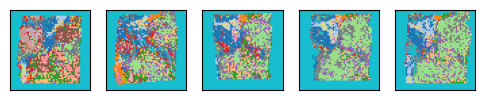

In [12]:
cmap = sns.color_palette('tab20')
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

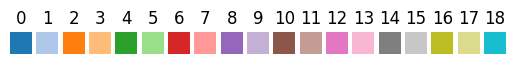

In [13]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))

In [ ]:
programs = [
    [9, 11],
    [5, 4, 3]
]

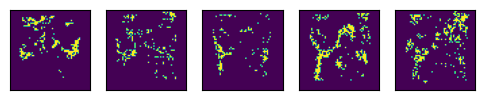

In [118]:
mask = neigh_ids == 14
fig, axs = plt.subplots(ncols=mask.shape[0], figsize=(6, 4))
for i, m in enumerate(mask):
    axs[i].imshow(m)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [96]:
# skimage.filters.gaussian(mask)
# fig, axs = plt.subplots(ncols=volume.shape[0], figsize=(6, 4))
# for i, m in enumerate(volume):
#     axs[i].imshow(m)
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])

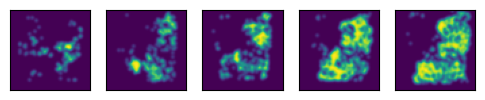

In [107]:
volume = np.zeros((neigh_ids.shape[0], neigh_ids.shape[1], neigh_ids.shape[2], neigh_ids.max()), dtype=np.float32)
for c in range(volume.shape[-1]):
    for n in range(volume.shape[0]):
        volume[n, ..., c] = skimage.filters.gaussian(neigh_ids[n]==c)
        
fig, axs = plt.subplots(ncols=volume.shape[0], figsize=(6, 4))
for i, m in enumerate(volume):
    axs[i].imshow(m[..., 5])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [108]:
section_positions = np.asarray([0, 4, 5, 6, 7])
volume.shape

(5, 60, 60, 18)

In [109]:
from torchio.transforms import Resize

In [110]:
section_range = (section_positions.min(), section_positions.max())

interp_volume = np.zeros((section_range[-1], volume.shape[1], volume.shape[2], volume.shape[3]), dtype=np.float32)
for i in range(volume.shape[0] - 1):
    l1, l2 = section_positions[i], section_positions[i+1]
    stack = rearrange(volume[i:i+2], 'n h w d -> d n h w')
    transform = Resize((l2 - l1, stack.shape[-2], stack.shape[-1]))
    resized = transform(stack)
    interp_volume[l1:l2] = rearrange(resized, 'd n h w -> n h w d')
    
blank = np.zeros((1, interp_volume.shape[-3], interp_volume.shape[-2], interp_volume.shape[-1]),
                 dtype=interp_volume.dtype)
interp_volume = np.vstack([
    blank,
    interp_volume,
    blank 
])

interp_volume.shape

(9, 60, 60, 18)

In [111]:
# interp_volume = np.stack([
#     skimage.filters.gaussian(x)
#     for x in rearrange(interp_volume, 'n h w d -> d h w n')
# ])
# interp_volume = rearrange(interp_volume, 'd h w n -> n h w d')
# interp_volume.shape

# blank = np.zeros((1, interp_volume.shape[-3], interp_volume.shape[-2], interp_volume.shape[-1]),
#                  dtype=interp_volume.dtype)
# interp_volume = np.vstack([
#     blank,
#     interp_volume,
#     blank 
# ])

In [112]:
transform = Resize((interp_volume.shape[0], interp_volume.shape[1] * 5, interp_volume.shape[2] * 5))

x = rearrange(interp_volume, 'n h w d -> d n h w')
resized = transform(x)
interp_volume = rearrange(resized, 'd n h w -> n h w d')
interp_volume.shape

(9, 300, 300, 18)

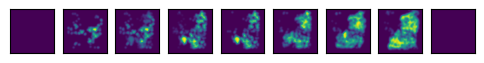

In [113]:
fig, axs = plt.subplots(ncols=interp_volume.shape[0], figsize=(6, 4))
for i, m in enumerate(interp_volume):
    axs[i].imshow(m[..., 5])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [104]:
interp_volume.max()

0.90970075

In [105]:
import skimage
vertices, faces, normals, values = skimage.measure.marching_cubes(interp_volume[..., 5], .1)

In [106]:
# vertices = np.array([[0, 0], [0, 20], [10, 0], [10, 10]])
# faces = np.array([[0, 1, 2], [1, 2, 3]])
# values = np.linspace(0, 1, len(vertices))
surface = (vertices, faces, values)

viewer = napari.view_surface(surface)  # add the surface

In [4]:
output_dir = '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/outputs'
config_filepath = os.path.join(output_dir, 'mushroom_config_local.yaml')
outputs_filepath = os.path.join(output_dir, 'outputs.pt')

In [5]:
data = torch.load(outputs_filepath)
data.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [6]:
for k, v in data.items():
    print(k, v.shape)

recon_embs torch.Size([2, 256, 60, 60])
recon_imgs torch.Size([2, 11622, 60, 60])
true_imgs torch.Size([2, 11622, 60, 60])
cluster_distances torch.Size([2, 60, 60, 20])
cluster_distance_volume torch.Size([200, 60, 60, 20])
cluster_centroids torch.Size([20, 256])
cluster_ids torch.Size([2, 60, 60])


In [7]:
def to_uint8(x):
    if isinstance(x, torch.Tensor):
        x = x.numpy()
    x = x.astype(np.float32)
    # x -= x.min()
    
    x /= x.max()
    x *= 255.
    x = x.astype(np.uint8)
    return x

In [8]:
viewer = napari.Viewer(ndisplay=3)

for i in range(data['cluster_distance_volume'])

In [ ]:
viewer.add_image(
    x,
    depiction='volume',
    rendering='iso',
    iso_threshold=10.,
    name=f'cluster {cluster}',
    visible=False
)